In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
df = pd.read_csv('/kaggle/input/google-stock-data/GOOGL.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602
...,...,...,...,...,...,...,...
4426,2022-03-18,2668.489990,2724.879883,2645.169922,2722.510010,2722.510010,2223100
4427,2022-03-21,2723.270020,2741.000000,2681.850098,2722.030029,2722.030029,1341600
4428,2022-03-22,2722.030029,2821.000000,2722.030029,2797.360107,2797.360107,1774800
4429,2022-03-23,2774.050049,2791.770020,2756.699951,2765.510010,2765.510010,1257700


In [4]:
data = df[['Date', 'Close']]
data

,Date,Close
0,2004-08-19,50.220219
1,2004-08-20,54.209209
2,2004-08-23,54.754753
3,2004-08-24,52.487488
4,2004-08-25,53.053055
...,...,...
4426,2022-03-18,2722.510010
4427,2022-03-21,2722.030029
4428,2022-03-22,2797.360107
4429,2022-03-23,2765.510010


/tmp/ipykernel_25/3250349648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


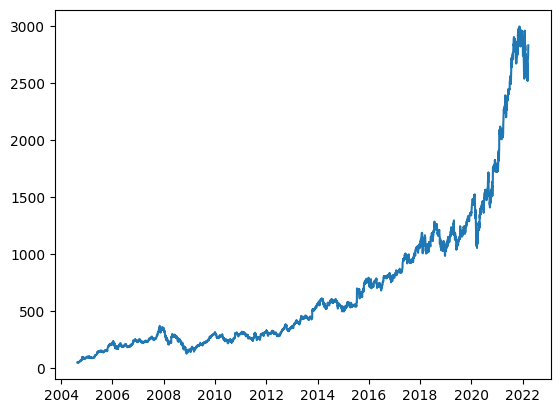

In [5]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close'])

In [6]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2004-08-30,51.056057,53.128128,54.009010,53.053055,52.487488,54.754753,54.209209,50.220219
2004-08-31,51.236237,51.056057,53.128128,54.009010,53.053055,52.487488,54.754753,54.209209
2004-09-01,50.175175,51.236237,51.056057,53.128128,54.009010,53.053055,52.487488,54.754753
2004-09-02,50.805805,50.175175,51.236237,51.056057,53.128128,54.009010,53.053055,52.487488
2004-09-03,50.055054,50.805805,50.175175,51.236237,51.056057,53.128128,54.009010,53.053055
...,...,...,...,...,...,...,...,...
2022-03-18,2722.510010,2676.780029,2665.610107,2583.959961,2519.020020,2597.409912,2648.590088,2668.399902
2022-03-21,2722.030029,2722.510010,2676.780029,2665.610107,2583.959961,2519.020020,2597.409912,2648.590088
2022-03-22,2797.360107,2722.030029,2722.510010,2676.780029,2665.610107,2583.959961,2519.020020,2597.409912


In [7]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[  51.056057,   53.128128,   54.00901 , ...,   54.754753,
          54.209209,   50.220219],
       [  51.236237,   51.056057,   53.128128, ...,   52.487488,
          54.754753,   54.209209],
       [  50.175175,   51.236237,   51.056057, ...,   53.053055,
          52.487488,   54.754753],
       ...,
       [2797.360107, 2722.030029, 2722.51001 , ..., 2583.959961,
        2519.02002 , 2597.409912],
       [2765.51001 , 2797.360107, 2722.030029, ..., 2665.610107,
        2583.959961, 2519.02002 ],
       [2831.439941, 2765.51001 , 2797.360107, ..., 2676.780029,
        2665.610107, 2583.959961]])

In [8]:
shifted_df_as_np.shape

(4424, 8)

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.9993206 , -0.99791424, -0.99731636, ..., -0.99681021,
        -0.99718048, -0.9998879 ],
       [-0.99919831, -0.9993206 , -0.99791424, ..., -0.99834905,
        -0.99681021, -0.99718048],
       [-0.99991847, -0.99919831, -0.9993206 , ..., -0.99796519,
        -0.99834905, -0.99681021],
       ...,
       [ 0.86465612,  0.81352795,  0.81385372, ...,  0.71981677,
         0.67574061,  0.72894555],
       [ 0.84303877,  0.86465612,  0.81352795, ...,  0.77523451,
         0.71981677,  0.67574061],
       [ 0.88778685,  0.84303877,  0.86465612, ...,  0.78281578,
         0.77523451,  0.71981677]])

In [10]:
X = shifted_df_as_np[:, 1:]
X = dc(np.flip(X, axis=1)) #flip theo đúng thứ tự thời gian
y = shifted_df_as_np[:, 0]
X.shape, y.shape

((4424, 7), (4424,))

In [11]:
split_val_index = int(len(X) * 0.5)
split_test_index = int(len(X) * 0.7)

In [12]:
X_train = X[:split_val_index]
X_val = X[split_val_index : split_test_index]
X_test = X[split_test_index:]

y_train = y[:split_val_index]
y_val = y[split_val_index : split_test_index]
y_test = y[split_test_index:]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((2212, 7), (884, 7), (1328, 7), (2212,), (884,), (1328,))

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_val = X_val.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2212, 7, 1), (1328, 7, 1), (2212, 1), (1328, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2212, 7, 1]),
 torch.Size([1328, 7, 1]),
 torch.Size([2212, 1]),
 torch.Size([1328, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
from torch.utils.data import DataLoader

batch_size = 16

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
input_size = 1 # at each time step, the model receive 1 feature as input
hidden_size = 20
num_stacked_layers = 2

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.drop = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, 1)
#         self.act = nn.Tanh()

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
#         out = self.drop(out)
#         out = self.act(out)
        out = self.fc(out[:, -1, :])
#         out = out.mean(dim=1)
#         out = self.fc(out)
        return out

model = LSTM(input_size, hidden_size, num_stacked_layers)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 20, num_layers=2, batch_first=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [21]:
train_losses, val_losses = [], []
min_val_loss = 100

In [22]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss_across_batches = running_loss / len(train_loader)
    train_losses.append(avg_loss_across_batches)
    print('Average train loss: {0:.3f}'.format(avg_loss_across_batches))
    print()

In [23]:
def validate_one_epoch(loader, min_val_loss):
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(loader)
    
    print('Average valid loss: {0:.6f}'.format(avg_loss_across_batches))
    val_losses.append(avg_loss_across_batches)
    if (avg_loss_across_batches < min_val_loss):
        min_val_loss = avg_loss_across_batches
        torch.save(model.state_dict(), '/kaggle/working/LSTM_model_timeSeries.ckpt')
        print('Saving model...')
    print(25 * '---')
    print()
    return min_val_loss

In [24]:
def test_one_epoch(loader):
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(loader)
    
    print('Loss: {0:.6f}'.format(avg_loss_across_batches))
    print(25 * '---')
    print()

In [25]:
lr = 5e-4
num_epochs = 30
loss_function = nn.MSELoss()
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)

In [26]:
min_val_loss = float('inf')
for epoch in range(num_epochs):
    train_one_epoch()
    min_val_loss = validate_one_epoch(val_loader, min_val_loss)

Epoch: 1
Average train loss: 0.169

Average valid loss: 0.050965
Saving model...
---------------------------------------------------------------------------

Epoch: 2
Average train loss: 0.002

Average valid loss: 0.053752
---------------------------------------------------------------------------

Epoch: 3
Average train loss: 0.002

Average valid loss: 0.052979
---------------------------------------------------------------------------

Epoch: 4
Average train loss: 0.002

Average valid loss: 0.046927
Saving model...
---------------------------------------------------------------------------

Epoch: 5
Average train loss: 0.002

Average valid loss: 0.040683
Saving model...
---------------------------------------------------------------------------

Epoch: 6
Average train loss: 0.002

Average valid loss: 0.038578
Saving model...
---------------------------------------------------------------------------

Epoch: 7
Average train loss: 0.002

Average valid loss: 0.040238
-------------------

In [27]:
with torch.no_grad():
    print('MSELoss on train set')
    train_predictions = model(X_train.to(device)).to('cpu').numpy()
    test_one_epoch(train_loader)
    
    print('MSELoss on validation set')
    val_predictions = model(X_val.to(device)).to('cpu').numpy()
    test_one_epoch(val_loader)
    
    print('MSELoss on test set')
    test_predictions = model(X_test.to(device)).to('cpu').numpy()
    test_one_epoch(test_loader)

MSELoss on train set
Loss: 0.000049
---------------------------------------------------------------------------

MSELoss on validation set
Loss: 0.000536
---------------------------------------------------------------------------

MSELoss on test set
Loss: 0.167950
---------------------------------------------------------------------------



In [28]:
train_predictions =  train_predictions.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])

In [29]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])

In [30]:
val_predictions = val_predictions.flatten()

dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = val_predictions
dummies = scaler.inverse_transform(dummies)

val_predictions = dc(dummies[:, 0])

In [31]:
dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = y_val.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_val = dc(dummies[:, 0])

In [32]:
test_predictions = test_predictions.flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])

In [33]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

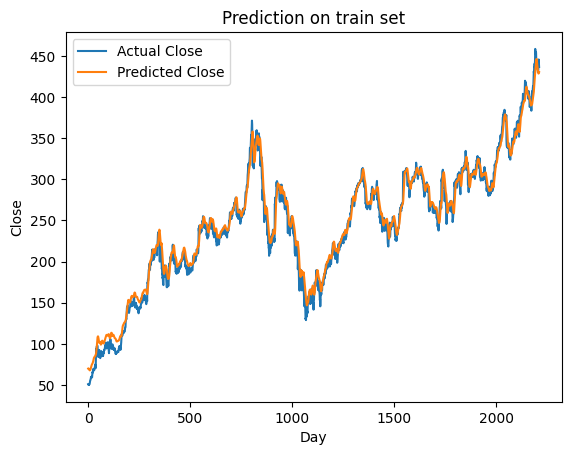

In [34]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on train set')
plt.legend()
plt.show()

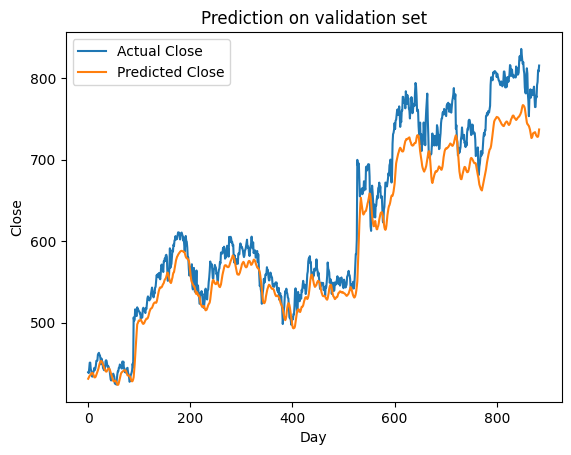

In [35]:
plt.plot(new_y_val, label='Actual Close')
plt.plot(val_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on validation set')
plt.legend()
plt.show()

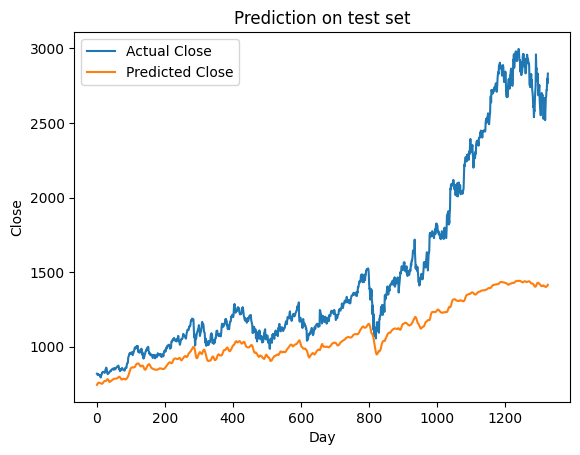

In [36]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on test set')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Train and valid loss lr = 0.000500')

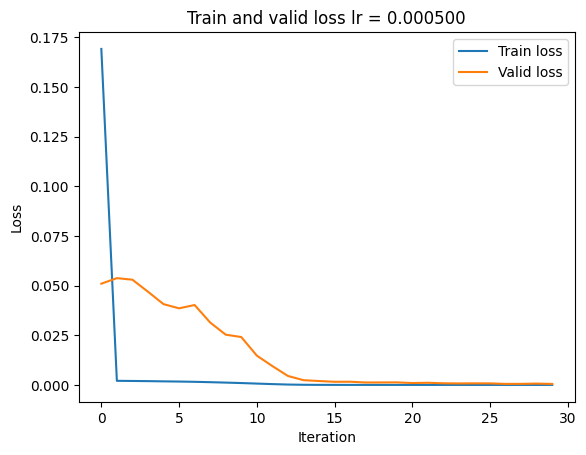

In [37]:
plt.plot(train_losses, label = 'Train loss')
plt.plot(val_losses, label = 'Valid loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and valid loss lr = {0:.6f}'.format(lr))